In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib notebook

In [2]:
mu_vals, sigma_vals = [[-1, 1], [-1, -1], [1, -1], [1, 1]], [[[.1, 0], [0, .1]] for i in range(4)]

samples = []
for mu, sigma in zip(mu_vals, sigma_vals):
    samples.append(np.random.multivariate_normal(mu, sigma, 500))

# Describing the General Gaussian Mixture Model

We can represent a Gaussian Mixture Model as follows

$$p(\mathbf{x}) = \sum_{k=1}^K \pi_k(\mathbf{x}) \mathcal{N}(\mathbf{x} | \mu_k, \Sigma_k)$$

In other words, given a random sample $\mathbf{x}$ we assume that the probability density function of $\mathbf{x}$ is given by a linear combination of Gaussian distributions. Alternatively, we can introduce a conditioning variable $\mathbf{z}$ and write the above model in the following way

$$p(\mathbf{x}) = \sum_{\mathbf{z}} p(\mathbf{z})p(\mathbf{x} | \mathbf{z})$$

where $\mathbf{z}$ is $K$-dimensional and has some $z_k = 1$ for some $k$ and $z_k = 0$ for all other values of $k$. Then we stipulate that $p(z_k = 1) = \pi_k$ and that $\pi_k$ is defined such that $0 \leq \pi_k \leq 1$ and $ \sum_{k=1}^K \pi_k = 1$. Similarly, we state $p(\mathbf{x} | z_k = 1) = \mathcal{N}(\mathbf{x} | \mu_k, \Sigma_k)$. As such, we can use the 1-of-$K$ representation for $\mathbf{z}$ to write

$$p(z) = \prod_{k=1}^K \pi_k^{z_k} \\
  p(\mathbf{x} | \mathbf{z}) = \prod_{k=1}^K \mathcal{N}(\mathbf{x} | \mu_k, \Sigma_k)^{z_k}$$
  
The marginal distribution $p(\mathbf{x})$ of $\mathbf{x}$ can be acquired by summing the joint distribution $p(\mathbf{z})p(\mathbf{x}|\mathbf{z})$ over all possible 1-of-K representations of $\mathbf{z}$, i.e.

$$p(\mathbf{x}) = \sum_{\mathbf{z}} p(\mathbf{x}|\mathbf{z})p(\mathbf{z})$$

In this way, we have represented any observed data point $\mathbf{x}$ sampled from the mixture as a distribution over some latent variable $\mathbf{z}$. 

In [21]:
def initialParams(K, muSpread, sigmaWidth):
    means = [np.random.uniform(low=-muSpread, high=muSpread, size=2) for _ in range(K)]
    
    sigmas = [sigmaWidth * np.eye(2) for _ in range(K)]
    
    pi = [1/K] * K
    
    return {'mu': means, 'sigma': sigmas, 'pi': pi, 'K': K}

def expectation(data, parameters):
    # Evaluate responsibilities
    N = len(data)
    K = parameters['K']
    mu = parameters['mu']
    sigma = parameters['sigma']
    pi = parameters['pi']
    
    gammas = np.empty((N, K))
    
    for n in range(N):
        x_n = data[n, :]
        samples = np.array([multivariateNormal(x_n, mu[j], sigma[j]) for j in range(K)])
        for k in range(K):
            gamma_num = pi[k] * samples[k]
            gamma_denom = np.sum(pi * samples)

            gamma_nk = gamma_num / gamma_denom

            gammas[n, k] = gamma_nk
        
    return gammas

def multivariateNormal(x, mu, sigma):
    # Sample a single point from N(x | mu, sigma)
    sigma_inv = np.linalg.inv(sigma)
    diff = x - mu
    sigma_sqrt = np.sqrt(np.linalg.det(sigma))
    n = len(mu)
    
    # Calculate inverse of coefficient
    Z = (2 * np.pi) ** (n / 2) * sigma_sqrt
    
    # Calculate sample
    sample = (1 / Z) * np.exp( -.5 * diff.T @ sigma_inv @ diff)
    
    return sample
    

def maximization(data, gammas, parameters):
    mu_old = parameters['mu']
    sigma_old = parameters['sigma']
    pi_old = parameters['pi']
    K = parameters['K']
    N = len(data)
    
    mu_new = np.zeros_like(mu_old)
    sigma_new = np.zeros_like(sigma_old)
    pi_new = np.empty_like(pi_old)

    for k in range(K):
        N_k = np.sum(gammas[:, k])
        pi_new[k] = N_k / N
        for n in range(N):
            mu_new[k] += (1 / N_k) * data[n, :] * gammas[n, k]
            sigma_new[k] += (1 / N_k) * gammas[n, k] * np.outer((data[n, :] - mu_new[k]), (data[n, :] - mu_new[k]))
        
    parameters['mu'] = mu_new
    parameters['sigma'] = sigma_new
    parameters['pi'] = pi_new
    
    return parameters

def hasConverged(logLikelihood, prevLikelihood, threshold=.1):          
    if np.abs(logLikelihood - prevLikelihood) < threshold:
        return True
    return False

def calcLogLikelihood(data, parameters):
    N = len(data)
    K = parameters['K']
    mu = parameters['mu']
    sigma = parameters['sigma']
    pi = parameters['pi']
    logLikelihood = 0
    partialSum = 1

    for n in range(N):
        logLikelihood += np.log(partialSum)
        partialSum = 0
        for k in range(K):
            partialSum += pi[k] * multivariateNormal(data[n, :], mu[k], sigma[k])

        return logLikelihood
    
def plotEM(data, parameters, ax):
    colors = ['red', 'cyan', 'green', 'black']
    K = parameters['K']
    
    for k in range(K):
        mu = parameters['mu'][k]
        sigma = parameters['sigma'][k]
        color = k % len(colors)
        plotContour(mu, sigma, ax, color=colors[color], numContours=5)
        

def runEM(data, parameters=None, plot=True):
    if not parameters:
        # Adjust initial parameter generation as desired.
        parameters = initialParams(4, .3, .02)
        prevLikelihood = 0
        logLikelihood = 1
        
    for _ in range(10):
    # while not hasConverged(logLikelihood, prevLikelihood):
        gammas = expectation(data, parameters)
        parameters = maximization(data, gammas, parameters)
        prevLikelihood = logLikelihood
        logLikelihood = calcLogLikelihood(data, parameters)
#         if plot:
#             plotEM(data, parameters, plt.gca())   
            
    plotEMResults(data, parameters['K'], parameters)
    
def plotContour(mu,sigma,ax,color='blue',numContours=3):
    eigvalues,eigvectors = np.linalg.eig(sigma)
    primaryEigvector = eigvectors[:,0]
    angle = computeRotation(primaryEigvector)
    isoProbContours = [Ellipse(mu,
                               l*np.sqrt(eigvalues[0]),
                               l*np.sqrt(eigvalues[1]),
                               alpha=0.3/l,color=color,
                              angle=angle) 
                       for l in range(1,numContours+1)]
    [ax.add_patch(isoProbContour) for isoProbContour in isoProbContours]

def computeRotation(vector):
    return (180/np.pi)*np.arctan2(vector[1],vector[0])

def dataScatter(data,color='grey'):
    plt.scatter(data[:,0],data[:,1],color=color,edgecolor=None,alpha=0.1)
    return

def plotEMResults(dataset,K,parameters):
    plt.figure()
    dataScatter(dataset)
    for idx in range(K):
        mu = parameters['mu'][idx]
        sigma = parameters['sigma'][idx]
        color = idx % (len(colors))
        plotContour(mu,sigma,plt.gca(),color=colors[color],numContours=5)

<IPython.core.display.Javascript object>


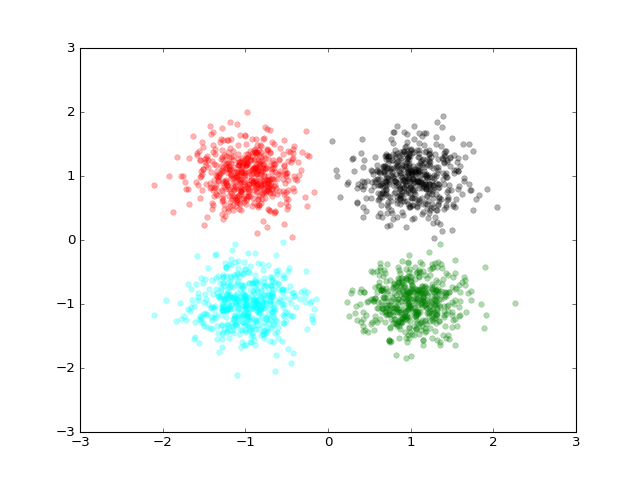

In [4]:
fig, ax = plt.subplots(1)
colors = ['red', 'cyan', 'green', 'black']
for sample, color in zip(samples, colors):
    ax.plot(sample[:, 0], sample[:, 1], '.',  c=color, alpha=0.3, markersize=10)

In [5]:
data = np.vstack((samples[0], samples[1]))
data = np.vstack((data, samples[2]))
data = np.vstack((data, samples[3]))

<IPython.core.display.Javascript object>


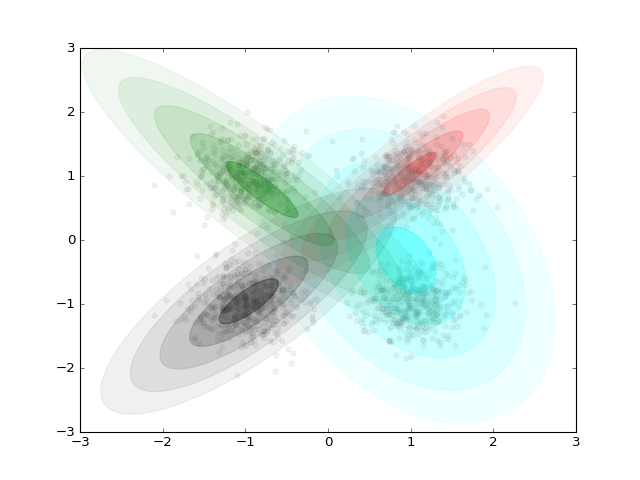

In [22]:
runEM(data)